##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# JAX で TensorFlow Probability を使用する

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/TensorFlow_Probability_on_JAX.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td> <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/TensorFlow_Probability_on_JAX.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a> </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/TensorFlow_Probability_on_JAX.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

TensorFlow Probability（TFP）は、確率論的推論と統計分析のためのライブラリであり、[JAX](https://github.com/google/jax) でも使用できるようになりました。JAX は構成可能な関数変換に基づく高速な数値計算のためのライブラリです。

JAX では、多くの TFP ユーザーが使い慣れている TFP の抽象化と API を維持しながら、通常の TFP の最も便利な機能の多くがサポートされています。

## セットアップ

JAX で TFP を使用する場合は TensorFlow には**依存しません**。この Colab から TensorFlow を完全にアンインストールしましょう。

In [ ]:
!pip uninstall tensorflow -y -q

TFP の最新のナイトリービルドを使用して、JAX に TFP をインストールします。

In [ ]:
!pip install -Uq tfp-nightly[jax] > /dev/null

いくつかの便利な Python ライブラリをインポートします。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


いくつかの基本的な JAX 機能もインポートします。

In [ ]:
import jax.numpy as jnp
from jax import grad
from jax import jit
from jax import random
from jax import value_and_grad
from jax import vmap

## JAX での TFP のインポート

JAX で TFP を使用するには、`jax` "サブストレート" をインポートして、通常の `tfp` と同じように使用します。

In [ ]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## デモ: ベイズロジスティック回帰

JAX バックエンドで何ができるかを示すために、古典的な Iris データセットに適用されるベイズロジスティック回帰を実装します。

まず、Iris データセットをインポートして、いくつかのメタデータを抽出します。


In [ ]:
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[-1]
num_classes = len(iris.target_names)

`tfd.JointDistributionCoroutine` を使用してモデルを定義します。重みとバイアス項の両方を標準正規事前分布し、サンプリングされたラベルをデータに固定する `target_log_prob` 関数を記述します。

In [ ]:
Root = tfd.JointDistributionCoroutine.Root
def model():
  w = yield Root(tfd.Sample(tfd.Normal(0., 1.),
                            sample_shape=(num_features, num_classes)))
  b = yield Root(
      tfd.Sample(tfd.Normal(0., 1.), sample_shape=(num_classes,)))
  logits = jnp.dot(features, w) + b
  yield tfd.Independent(tfd.Categorical(logits=logits),
                        reinterpreted_batch_ndims=1)


dist = tfd.JointDistributionCoroutine(model)
def target_log_prob(*params):
  return dist.log_prob(params + (labels,))

`dist` からサンプリングして、MCMC の初期状態を生成します。次に、ランダムキーと初期状態を受け取り、No-U-Turn-Sampler (NUTS) から 500 個のサンプルを生成する関数を定義します。`jit` のような JAX 変換を使用して、XLA を使用して NUTS サンプラーをコンパイルできることに注意してください。

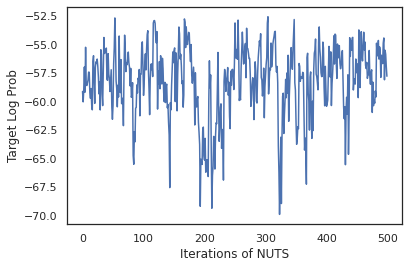

In [ ]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_params = tuple(dist.sample(seed=init_key)[:-1])

@jit
def run_chain(key, state):
  kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
  return tfp.mcmc.sample_chain(500,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=500,
      seed=key)

states, log_probs = run_chain(sample_key, init_params)
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of NUTS')
plt.show()

サンプルを使用して、重みの各セットの予測確率を平均することにより、ベイズモデル平均化 (BMA) を実行します。

最初に、特定のパラメータのセットに対して各クラスの確率を生成する関数を作成します。`dist.sample_distributions` を使用して、モデルの最終的な分布を取得できます。

In [ ]:
def classifier_probs(params):
  dists, _ = dist.sample_distributions(seed=random.PRNGKey(0),
                                       value=params + (None,))
  return dists[-1].distribution.probs_parameter()

サンプルのセットに対して `vmap(classifier_probs)` を実行して、各サンプルの予測クラス確率を取得します。次に、各サンプルの平均精度とベイズモデル平均化からの精度を計算します。

In [ ]:
all_probs = jit(vmap(classifier_probs))(states)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.96952
BMA accuracy: 0.97999996


BMA はエラー率をほぼ 3 分の 1 に減らしました！

## 基礎

JAX 上の TFP には TF と同じ API があり、`tf.Tensor` などの TF オブジェクトを受け入れる代わりに、JAX アナログを受け入れます。たとえば、`tf.Tensor` が以前に入力として使用されていた場合、API は JAX `DeviceArray` を想定するようになりました。TFP メソッドは `tf.Tensor` を返す代わりに、`DeviceArray` を返します。JAX 上の TFP は、`DeviceArray` のリストやディクショナリなど、JAX オブジェクトのネストされた構造でも機能します。


## 分布

TFP の分布のほとんどは、JAX でサポートされています。これは対応する TF の分布と非常によく似たセマンティクスを持ちます。また、[JAX Pytrees](https://jax.readthedocs.io/en/latest/pytrees.html) として登録されているため、JAX 変換された関数の入力および出力になります。

### 基本的な分布

分布の `log_prob` メソッドも同じように機能します。

In [ ]:
dist = tfd.Normal(0., 1.)
print(dist.log_prob(0.))

-0.9189385


分布からサンプリングするには、`seed` キーワード引数として `PRNGKey`（または整数のリスト）を明示的に渡す必要があります。シードを明示的に渡さないと、エラーがスローされます。

In [ ]:
tfd.Normal(0., 1.).sample(seed=random.PRNGKey(0))

DeviceArray(-0.20584226, dtype=float32)

分布の形状セマンティクスは JAX でも同じです。ここで、分布にはそれぞれ `event_shape` と  `batch_shape` があり、多くのサンプルをドローすると、さらに `sample_shape` 次元が追加されます。

たとえば、ベクトルパラメータを持つ `tfd.MultivariateNormalDiag` は、ベクトルイベント形状と空のバッチ形状を持ちます。

In [ ]:
dist = tfd.MultivariateNormalDiag(
    loc=jnp.zeros(5),
    scale_diag=jnp.ones(5)
)
print('Event shape:', dist.event_shape)
print('Batch shape:', dist.batch_shape)

Event shape: (5,)
Batch shape: ()


一方、ベクトルでパラメーター化された `tfd.Normal` は、スカラーイベント形状とベクトルバッチ形状になります。

In [ ]:
dist = tfd.Normal(
    loc=jnp.ones(5),
    scale=jnp.ones(5),
)
print('Event shape:', dist.event_shape)
print('Batch shape:', dist.batch_shape)

Event shape: ()
Batch shape: (5,)


サンプルの `log_prob` を取得するセマンティクスは、JAX でも同じように機能します。

In [ ]:
dist =  tfd.Normal(jnp.zeros(5), jnp.ones(5))
s = dist.sample(sample_shape=(10, 2), seed=random.PRNGKey(0))
print(dist.log_prob(s).shape)

dist =  tfd.Independent(tfd.Normal(jnp.zeros(5), jnp.ones(5)), 1)
s = dist.sample(sample_shape=(10, 2), seed=random.PRNGKey(0))
print(dist.log_prob(s).shape)

(10, 2, 5)
(10, 2)


JAX `DeviceArray` は NumPy や Matplotlib などのライブラリと互換性があるため、サンプルをプロット関数に直接フィードできます。

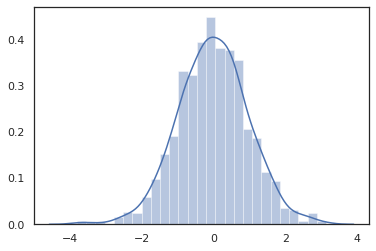

In [ ]:
sns.distplot(tfd.Normal(0., 1.).sample(1000, seed=random.PRNGKey(0)))
plt.show()

`Distribution` メソッドは JAX 変換と互換性があります。

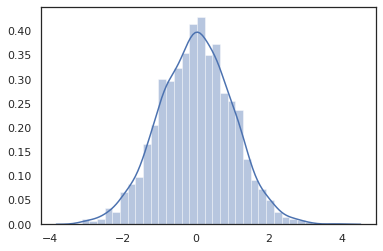

In [ ]:
sns.distplot(jit(vmap(lambda key: tfd.Normal(0., 1.).sample(seed=key)))(
    random.split(random.PRNGKey(0), 2000)))
plt.show()

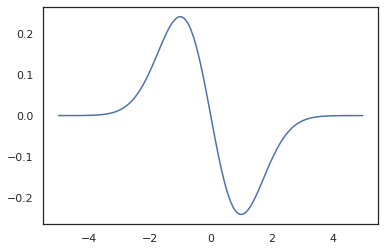

In [ ]:
x = jnp.linspace(-5., 5., 100)
plt.plot(x, jit(vmap(grad(tfd.Normal(0., 1.).prob)))(x))
plt.show()

TFP 分布は JAX pytree ノードとして登録されているため、分布を入力または出力として関数を記述し、`jit` を使用して変換できますが、`vmap` 関数の引数としてはまだサポートされていません。

In [ ]:
@jit
def random_distribution(key):
  loc_key, scale_key = random.split(key)
  loc, log_scale = random.normal(loc_key), random.normal(scale_key)
  return tfd.Normal(loc, jnp.exp(log_scale))
random_dist = random_distribution(random.PRNGKey(0))
print(random_dist.mean(), random_dist.variance())

0.14389051 0.081832744


### 変換された分布

変換された分布、つまりサンプルが `Bijector` を通過する分布も、そのままで機能します（バイジェクターも機能します。以下を参照してください）。

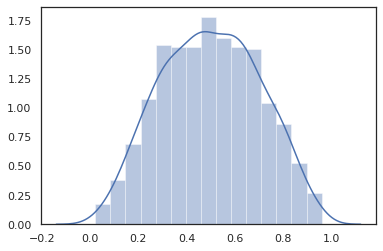

In [ ]:
dist = tfd.TransformedDistribution(
    tfd.Normal(0., 1.),
    tfb.Sigmoid()
)
sns.distplot(dist.sample(1000, seed=random.PRNGKey(0)))
plt.show()

### 同時分布

TFP はコンポーネントの分布を複数の確率変数上の単一の分布に結合できるように `JointDistribution` を提供しています。現在、TFP は 3 つのコアバリアント (`JointDistributionSequential`、`JointDistributionNamed`、および `JointDistributionCoroutine`) を提供しており、これらはすべて JAX でサポートされています。`AutoBatched` バリアントもすべてサポートされています。

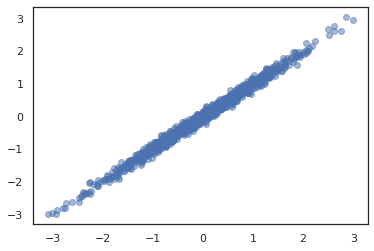

In [ ]:
dist = tfd.JointDistributionSequential([
  tfd.Normal(0., 1.),
  lambda x: tfd.Normal(x, 1e-1)
])
plt.scatter(*dist.sample(1000, seed=random.PRNGKey(0)), alpha=0.5)
plt.show()

In [ ]:
joint = tfd.JointDistributionNamed(dict(
    e=             tfd.Exponential(rate=1.),
    n=             tfd.Normal(loc=0., scale=2.),
    m=lambda n, e: tfd.Normal(loc=n, scale=e),
    x=lambda    m: tfd.Sample(tfd.Bernoulli(logits=m), 12),
))
joint.sample(seed=random.PRNGKey(0))

{'e': DeviceArray(3.376818, dtype=float32),
 'm': DeviceArray(2.5449684, dtype=float32),
 'n': DeviceArray(-0.6027825, dtype=float32),
 'x': DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)}

In [ ]:
Root = tfd.JointDistributionCoroutine.Root
def model():
  e = yield Root(tfd.Exponential(rate=1.))
  n = yield Root(tfd.Normal(loc=0, scale=2.))
  m = yield tfd.Normal(loc=n, scale=e)
  x = yield tfd.Sample(tfd.Bernoulli(logits=m), 12)

joint = tfd.JointDistributionCoroutine(model)

joint.sample(seed=random.PRNGKey(0))

StructTuple(var0=DeviceArray(0.17315261, dtype=float32), var1=DeviceArray(-3.290489, dtype=float32), var2=DeviceArray(-3.1949058, dtype=float32), var3=DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

### その他の分布

ガウス過程は JAX モードでも機能します。

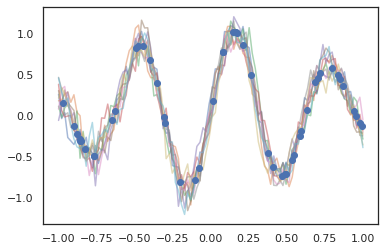

In [ ]:
k1, k2, k3 = random.split(random.PRNGKey(0), 3)
observation_noise_variance = 0.01
f = lambda x: jnp.sin(10*x[..., 0]) * jnp.exp(-x[..., 0]**2)
observation_index_points = random.uniform(
    k1, [50], minval=-1.,maxval= 1.)[..., jnp.newaxis]
observations = f(observation_index_points) + tfd.Normal(
    loc=0., scale=jnp.sqrt(observation_noise_variance)).sample(seed=k2)

index_points = jnp.linspace(-1., 1., 100)[..., jnp.newaxis]

kernel = tfpk.ExponentiatedQuadratic(length_scale=0.1)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10, seed=k3)
for i in range(10):
  plt.plot(index_points, samples[i], alpha=0.5)
plt.plot(observation_index_points, observations, marker='o', linestyle='')
plt.show()

隠れマルコフモデルもサポートされています。

In [ ]:
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])

observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

print(model.mean())
print(model.log_prob(jnp.zeros(7)))
print(model.sample(seed=random.PRNGKey(0)))

[3.       6.       7.5      8.249999 8.625001 8.812501 8.90625 ]


/usr/local/lib/python3.6/dist-packages/tensorflow_probability/substrates/jax/distributions/hidden_markov_model.py:483: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  'HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug '


-19.855635
[ 1.3641367  0.505798   1.3626463  3.6541772  2.272286  15.10309
 22.794212 ]


`PixelCNN` のようないくつかの分布は、TensorFlow または XLA の非互換性に厳密に依存しているため、まだサポートされていません。

## バイジェクター

現在、ほとんどの TFP バイジェクターが JAX でサポートされています。

In [ ]:
tfb.Exp().inverse(1.)

DeviceArray(0., dtype=float32)

In [ ]:
bij = tfb.Shift(1.)(tfb.Scale(3.))
print(bij.forward(jnp.ones(5)))
print(bij.inverse(jnp.ones(5)))

[4. 4. 4. 4. 4.]
[0. 0. 0. 0. 0.]


In [ ]:
b = tfb.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=None)
print(b.forward(x=[0., 0., 0.]))
print(b.inverse(y=[[1., 0], [.5, 2]]))

[[1. 0.]
 [0. 1.]]
[0.6931472 0.5       0.       ]


In [ ]:
b = tfb.Chain([tfb.Exp(), tfb.Softplus()])
# or:
# b = tfb.Exp()(tfb.Softplus())
print(b.forward(-jnp.ones(5)))

[1.3678794 1.3678794 1.3678794 1.3678794 1.3678794]


バイジェクターは、`jit`、`grad` および `vmap` などの JAX 変換と互換性があります。

In [ ]:
jit(vmap(tfb.Exp().inverse))(jnp.arange(4.))

DeviceArray([     -inf, 0.       , 0.6931472, 1.0986123], dtype=float32)

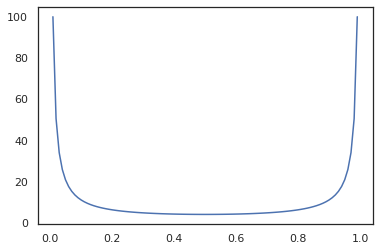

In [ ]:
x = jnp.linspace(0., 1., 100)
plt.plot(x, jit(grad(lambda x: vmap(tfb.Sigmoid().inverse)(x).sum()))(x))
plt.show()

`RealNVP` および `FFJORD` などの一部のバイジェクターはまだサポートされていません。

## MCMC

`tfp.mcmc` も JAX に移植されているので、ハミルトニアンモンテカルロ（HMC）や No-U-Turn-Sampler（NUTS）などのアルゴリズムを JAX で実行できます。

In [ ]:
target_log_prob = tfd.MultivariateNormalDiag(jnp.zeros(2), jnp.ones(2)).log_prob

TF 上の TFP とは異なり、`seed` キーワード引数を使用して、`PRNGKey` を `sample_chain` に渡す必要があります。

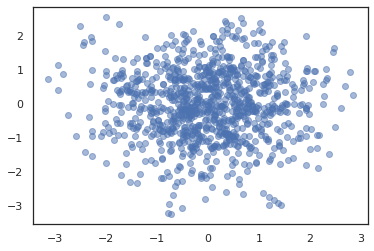

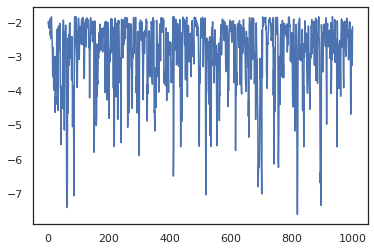

In [ ]:
def run_chain(key, state):
  kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-1)
  return tfp.mcmc.sample_chain(1000,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      seed=key)
states, log_probs = jit(run_chain)(random.PRNGKey(0), jnp.zeros(2))
plt.figure()
plt.scatter(*states.T, alpha=0.5)
plt.figure()
plt.plot(log_probs)
plt.show()

複数のチェーンを実行するには、状態のバッチを `sample_chain` に渡すか、`vmap` を使用します（ただし、2 つのアプローチのパフォーマンスの違いについてはまだ調査されていません）。

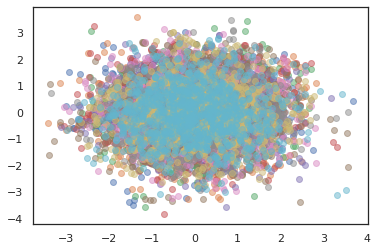

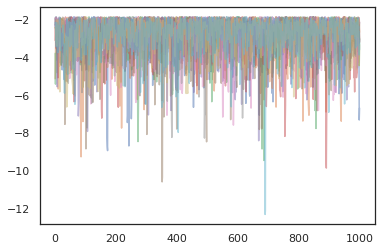

In [ ]:
states, log_probs = jit(run_chain)(random.PRNGKey(0), jnp.zeros([10, 2]))
plt.figure()
for i in range(10):
  plt.scatter(*states[:, i].T, alpha=0.5)
plt.figure()
for i in range(10):
  plt.plot(log_probs[:, i], alpha=0.5)
plt.show()

## オプティマイザ

JAX 上の TFP は、BFGS や L-BFGS などのいくつかの重要なオプティマイザをサポートしています。単純なスケーリングされた 2 次損失関数を設定しましょう。

In [ ]:
minimum = jnp.array([1.0, 1.0])  # The center of the quadratic bowl.
scales = jnp.array([2.0, 3.0])  # The scales along the two axes.

# The objective function and the gradient.
def quadratic_loss(x):
  return jnp.sum(scales * jnp.square(x - minimum))

start = jnp.array([0.6, 0.8])  # Starting point for the search.

BFGS は、この損失の最小値を見つけることができます。

In [ ]:
optim_results = tfp.optimizer.bfgs_minimize(
    value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)
# Print out the total number of function evaluations it took. Should be 5.
print("Function evaluations: %d" % optim_results.num_objective_evaluations)

Function evaluations: 5


L-BFGS でもできます。

In [ ]:
optim_results = tfp.optimizer.lbfgs_minimize(
    value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)
# Print out the total number of function evaluations it took. Should be 5.
print("Function evaluations: %d" % optim_results.num_objective_evaluations)

Function evaluations: 5


L-BFGS で `vmap` を実行するために、単一の開始点の損失を最適化する関数を設定しましょう。

In [ ]:
def optimize_single(start):
  return tfp.optimizer.lbfgs_minimize(
      value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

all_results = jit(vmap(optimize_single))(
    random.normal(random.PRNGKey(0), (10, 2)))
assert all(all_results.converged)
for i in range(10):
  np.testing.assert_allclose(optim_results.position[i], minimum)
print("Function evaluations: %s" % all_results.num_objective_evaluations)

Function evaluations: [6 6 9 6 6 8 6 8 5 9]


## 注意事項

TF と JAX の間にはいくつかの基本的な違いがあり、一部の TFP の動作は、2 つのサブストレート間で異なり、すべての機能がサポートされているわけではありません。以下に例を示します。

- JAX 上の TFP は、JAX に存在するようなものがないため、`tf.Variable` などをサポートしていません。また、`tfp.util.TransformedVariable` のようなユーティリティもサポートされていません。
- `tfp.layers` は、Keras と `tf.Variable` に依存しているため、バックエンドではまだサポートされていません。
- `tfp.math.minimize` は、`tf.Variable` に依存しているため、JAX 上の  TFP では機能しません。
- JAX 上の TFP では、テンソル形状は常に具体的な整数値であり、TF 上の TFP のように不明/動的になることはありません。
- 疑似ランダム性は、TF と JAX で異なる方法で処理されます（付録を参照）。
- `tfp.experimental` のライブラリは、JAX サブストレートに存在することが保証されていません。
- Dtype プロモーションルールは TF と JAX で異なります。JAX 上の TFP は、一貫性を保つために、内部的に TF の dtype セマンティクスに従います。
- バイジェクターはまだ JAX pytrees として登録されていません。

JAX 上の TFP でサポートされている機能の完全なリストを確認するには、[API ドキュメント](https://www.tensorflow.org/probability/api_docs/python/tfp/substrates/jax)を参照してください。

## 結論

TFP の多くの機能が JAX でサポートされるようになりました。これらを利用して皆さんが何を構築するかを楽しみにしています。一部の機能はまだサポートされていません。皆さんにとって重要な機能がサポートされていない場合（またはバグを見つけた場合）は、[tfprobability@tensorflow.org](mailto:tfprobability@tensorflow.org) までご連絡ください。または、[Github リポジトリ](https://github.com/tensorflow/probability)で課題を作成してください。

## 付録：JAX の疑似ランダム性

JAX の疑似乱数生成（PRNG）モデルは*ステートレス*です。ステートフルモデルとは異なり、ランダムにドローするたびに進化する可変のグローバル状態はありません。JAX のモデルでは、32 ビット整数のペアのように機能する PRNG *キー*から始めます。これらのキーは、`jax.random.PRNGKey` を使用して作成できます。

In [ ]:
key = random.PRNGKey(0)  # Creates a key with value [0, 0]
print(key)

[0 0]


JAX の確率関数は、*確定的に*ランダム変量を生成するためのキーを使用します。つまり、それらを再度使用しないでください。たとえば、`key` を使用して正規分布の値をサンプリングできますが、他の場所で `key` を再度使用することはできません。さらに、`random.normal` に渡すと、同じ値が生成されます。

In [ ]:
print(random.normal(key))

-0.20584226


では、1 つのキーから複数のサンプルを抽出するにはどうしたらよいでしょうか。答えは*キー分割*です。基本的な考え方は、`PRNGKey` を複数に分割でき、新しいキーのそれぞれを独立したランダム性のソースとして扱うということです。

In [ ]:
key1, key2 = random.split(key, num=2)
print(key1, key2)

[4146024105  967050713] [2718843009 1272950319]


キー分割は確定的ですが、混沌としているため、新しいキーをそれぞれ使用して、個別のランダムサンプルをドローできるようになりました。

In [ ]:
print(random.normal(key1), random.normal(key2))

0.14389051 -1.2515389


JAX の確定的キー分割モデルの詳細については、[このガイド](https://github.com/google/jax/blob/main/docs/jep/263-prng.md)を参照してください。